# Topic 7 - How do we locate disease causing mutations?
## Combinatorial Pattern Matching

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Slack ice breaker
Dylan versus the Beatles?

## What is read mapping?
So far we've seen one way to process reads
* Assembly - f(reads) => genome (transcriptome)
We would really like to be able to compare DNA reads from an individual (you, me, everyone) and compare them against a reference human genome.

### Why?
To find mutations for an individual and for a subpopulation/group

But why? ... what do you think...?

One reason is to identify mutations that are correlated to a disease.

# What causes Ohdo Syndrome?

* Ohdo syndrome causes expressionless, "mask-like" face
* 2011 - biologists found a handful of mutations shared by multiple patients that then identified a single protein-truncating mutation responsible for Ohdo syndrome
* How can we study this in bioinformatics? 
    * Read mapping
    * Single nucleotide polymorphisms (SNPs)

### What is a SNP?
<img src="https://online.stat.psu.edu/stat555/sites/onlinecourses.science.psu.edu.stat555/files/snps/snps_reads_02/index.png">

## Why not use the algorithms we already have?

* Why not just assemble each persons genome? 
   * Expensive and error prone
* Other sequence alignment algorithms become runtime bottlenecks when we scale to millions of reads
* And finally, we can solve the problem in a more efficient way, so we should...

## Introduction to Multiple Pattern Matching
* Reads are a few hundred base pairs long
* When hunting for a cause of a genetic disorder, we can immediately eliminate areas of reference genome with exact matches

*Multiple Pattern Matching Problem:*

Input: ``text`` and a collection of ``patterns`` (shorter strings)

Output: All starting positions in ``text`` where a string from ``patterns`` appears as a substring.

*Brute force solution*
* Consider each pattern as its own car driving down a road (``text``)
* It would work but as we move each pattern down the same ``text`` we realize how inefficent this is: $O(|text|*|patterns|)$ ... brutal

## Herding Patterns into a trie
Trie - directed acyclic graph written ``trie(patterns)`` has the following properties:
* Single root node with indegree of 0; all other nodes have indegree of 1
* Each edge of ``trie(patterns)`` is labeled with a letter of the alphabet
* Edges leading out a given node have distinct labels
* Every string in ``patterns`` is spelled out by concatenating the letters along some path from the root downward
* Every path from the root to a leaf spells a string from ``patterns``.

## Example trie(patterns)
<pre>
patterns = ['ATAGA','ATC','GAT']
</pre>
Take 2 minutes and try to make the trie...

<img src="example_trie.png" width=200>

**Exercise 1**: Trie construction problem - Construct a trie from a collection of patterns

Input: A collection of strings (``patterns``)

Output: ``trie(patterns)`` in the form a networkx direct graph.

In [3]:
# For the record here is what worked for me. 
#!sudo chown -R $(whoami) /usr/local/lib/pkgconfig
#!chmod u+w /usr/local/lib/pkgconfig
#!brew install graphviz
#!            pip install pygraphviz --install-option="--include-path=/usr/include/graphviz" --install-option="--library-path=/usr/lib/graphviz/"
#pip install pygraphviz

In [4]:
# Just code to help you out here
%matplotlib inline

import networkx as nx
import pandas as pd
import copy

import matplotlib.pyplot as plt

def draw(A):
    return Image(A.draw(format='png', prog='dot'))

def to_adj(T):
    df = pd.DataFrame(nx.adjacency_matrix(T).todense(),index=T.nodes(),columns=T.nodes())
    for i in range(len(df)):
        for j in range(len(df)):
            if df.iloc[i,j] == 1:
                data = T.get_edge_data(df.index[i],df.columns[j])
                df.iloc[i,j] = data['label']
            else:
                df.iloc[i,j] = ""
    return df

def show(G):
    if graphviz_installed:
        # same layout using matplotlib with no labels
        pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
        #print(edge_labels)
        # Modify node fillcolor and edge color.
        #D.node_attr.update(color='blue', style='filled', fillcolor='yellow')
        #D.edge_attr.update(color='blue', arrowsize=1)
        A = nx.nx_agraph.to_agraph(G)
        # draw it in the notebook
        if display_available:
            display(draw(A))
        else:
            print(A)
    else:
        if display_available:
            display(to_adj(G))
        else:
            print(to_adj(G))

In [5]:
import networkx as nx

# Inputs: G - networkx graph, current - node name, c - character on edge
# Output: a neighbor of current that is reached by an edge that has label==c; otherwise None
def find_edge(G,current,c): 
    for n in G.neighbors(current):
        if n is None:
            return None
        data = G.get_edge_data(current,n)
        if data['label'] == c:
            return n
    return None

def trie_construction(patterns):
    G = nx.DiGraph()
    G.add_node('root')
    # Your solution here
    return G

patterns1 = ['ATAGA','ATC','GAT']
trie1 = trie_construction(patterns1)
show(trie1)

patterns2 = ['ananas','and','antenna','banana','bandana','nab','nana','pan']
trie2 = trie_construction(patterns2)
show(trie2)

NameError: name 'graphviz_installed' is not defined

*Applying the trie to multiple pattern matching*

Given a string ``text`` and ``trie(patterns)``, it is easy to see if a prefix of ``text`` matches any of our patterns. 

We just need to simply work through the graph. If we get to a leaf node, then we can output the path from the root to the leaf node.

In [6]:
def prefix_trie_matching(text,trie):
    symbol = text[0]
    v = "root"
    i = 0
    while i < len(text):            
        if len(list(trie.neighbors(v))) == 0:
            return symbol
        else:
            w = find_edge(trie,v,symbol[-1])
            if w is None:
                return None
            symbol += text[i]
            i += 1
            v = w
    return None
            
print(prefix_trie_matching("bana",trie2))
print(prefix_trie_matching("bananaabacadaba1",trie2))

NameError: name 'trie2' is not defined

## Can you write a function that finds whether any strings in patterns match a substring of text?

*Exercise 2:* Find whether any strings in ``patterns`` match a substring of ``text`` starting at position $i$. 

Input: ``text`` and ``trie(patterns)``

Output: all of the starting locations $i$ where a string in ``patterns`` matches a substring of ``text``.

In [6]:
def trie_matching(text,trie):
    positions = []
    # YOUR SOLUTION HERE
    return positions

positions = trie_matching("bananablahblahantennanabnablkjdf",trie2)
positions

[0, 2, 4, 14, 19, 21, 24]

## Suffix Tries and Trees
### An assumption and problems
There is a key assumption we are making with our prefix_trie_matching function. The assumption is that no string in pattern is a prefix of another string in pattern. 

We also have a problem that comes up in practice. We are storing the entire trie in memory. A collection of reads may consume upwards of 1 TB. That is a problem for most systems.

To solve this problem we will switch things up and instead of focusing on a data structure (trie) for ``patterns`` we will focus on a suffix trie for ``text``.

A suffix trie is the trie formed from all suffixes of ``text``.

We will be appending a dollar-sign ("$") to ``text`` in order to mark the end of ``text``. There is nothing special about this symbol.

We will also label each leaf of the resulting trie by the starting position of the suffix whose path through the tre ends at this leaf. 

### How do we use suffix tries for pattern matching?
If we want to match a single string ``pattern`` to ``text``, then we first note that if ``pattern`` matches a substring of ``text`` starting at position $i$, then ``pattern`` must also appear at the beginning of the suffix of ``text`` starting at position $i$.

We can easily determine if ``pattern`` occurs in the suffix trie by starting at the root and spelling the symbols of pattern downward.

**Take 2 minutes**, and see if you can construct a portion of a suffix trie for
**panamabananas$**

Make sure you put the starting position at the leaf

How would determine if bana (pattern) matches?

*Exercise 3:* Construct a suffix trie

Input: ``text``

Output: a suffix trie as a networkx object.

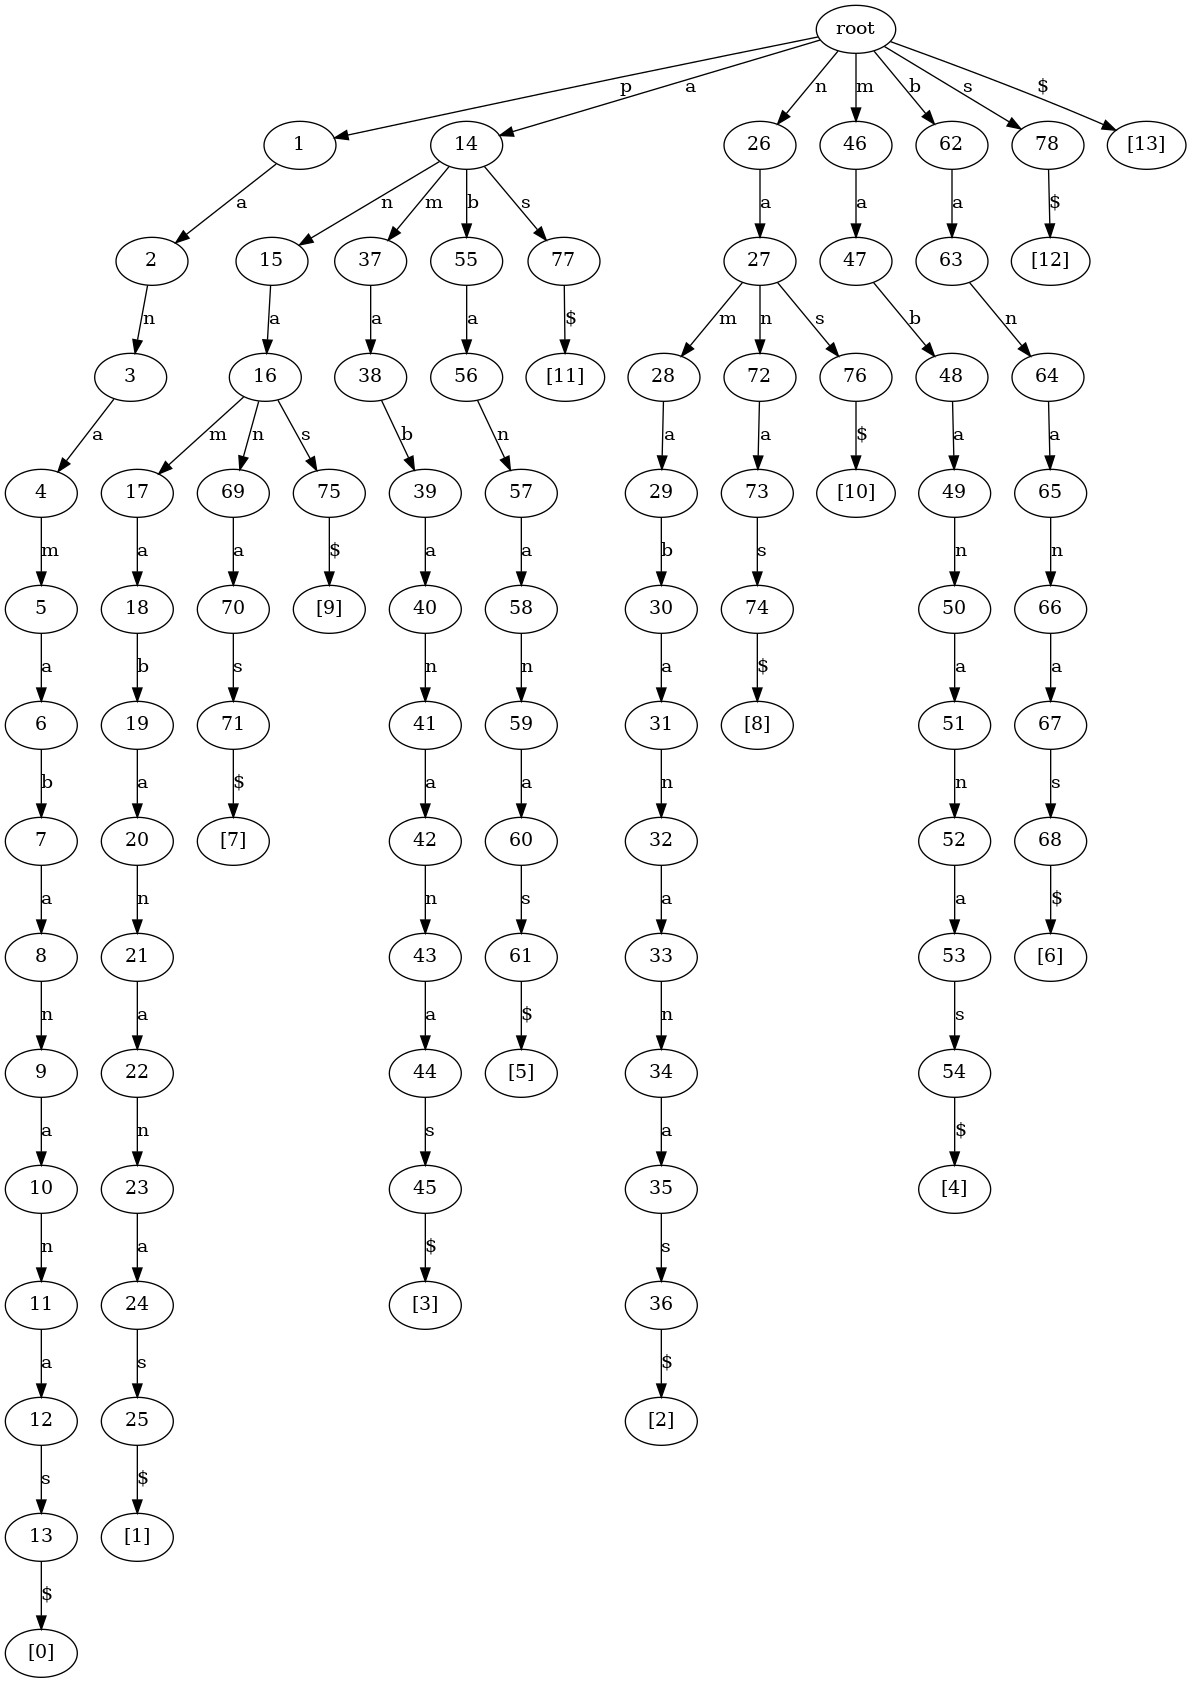

In [7]:
def suffix_trie(text):
    G = nx.DiGraph()
    G.add_node('root')
    # Your solution here
    return G

trie3 = suffix_trie("panamabananas$")
show(trie3)

### Shortcomings
One shortcoming with the suffix trie are the trivial edges (edges that just form a simple sequence with no branching). 

We can overcome this by producing a suffix tree that concatenates edges together when possible. 

There is a linear way to construct the suffix tree, but we will **not** do this in this lab. Further, we would not store the simple sequence itself. We would store a pointer and a length.

We are going to keep things on a conceptual level. In other words, to solve the next exercise, don't worry about memory.

In our current situation, each edge in a suffix trie is labeled by a single symbol. It is **unclear where this symbol came from in text**. 

To solve this, we can add another label for each edge referring to the position of this symbol in text.

If an edge in a trie corresponds to more than one position in text, then we assign it to its minimum starting position. For example consider the first **n** in a**n**amabananas, a**n**anas, and a**n**as. These are positions 2, 8,and 10. We assign this edge the minimum of these positions.

**Take a couple of minutes** and work on constructing the modified trie for panamabananas$.

Here is the pseudocode.

<img src="modifiedsuffixtrie.jpg" width=400>

**Exercise 4:** Modified suffix trie construction (not collapsed yet)

Input: A string ``text``

Output: Return a modified suffix trie as a networkx object using the method describe above

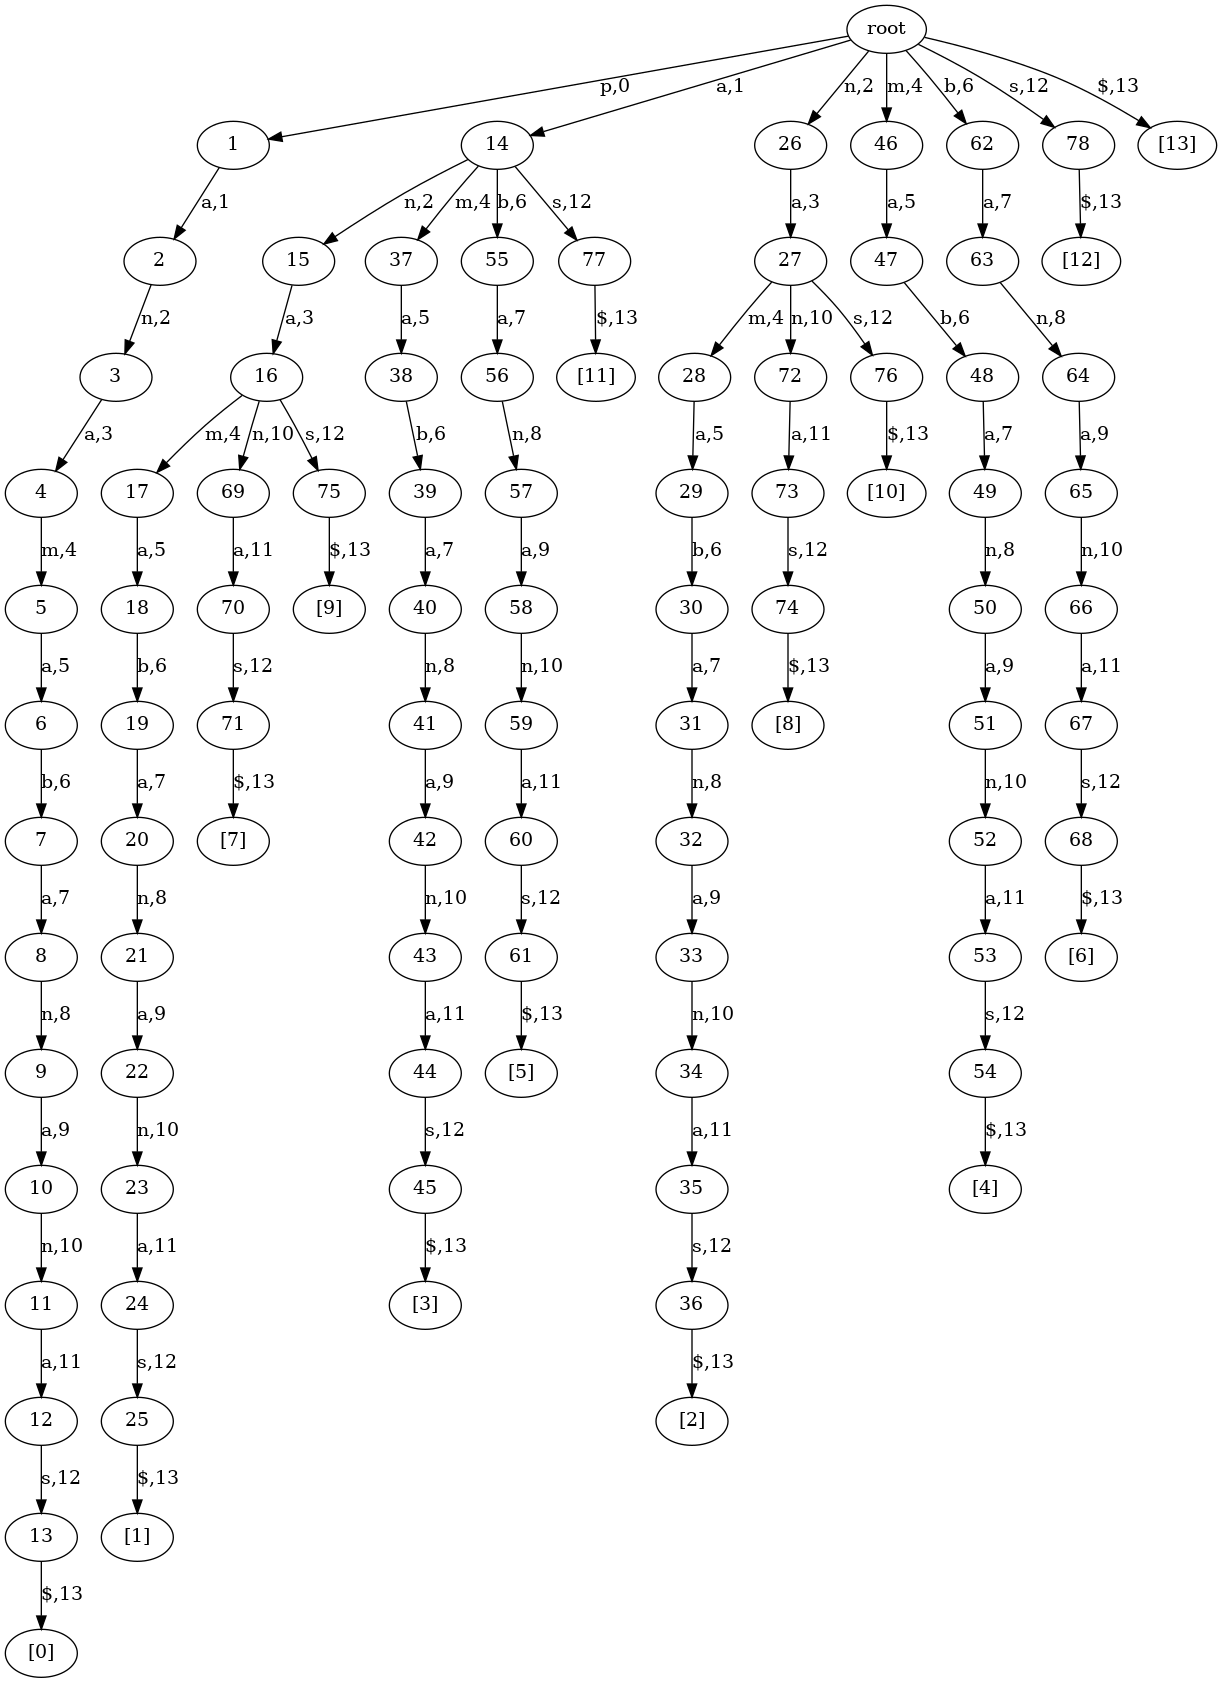

In [8]:
# Inputs: G - networkx graph, current - node name, c - character on edge
# Output: a neighbor of current that is reached by an edge that has label==c; otherwise None
def modified_find_edge(G,current,c):
    cv,j = c.split(",")
    j = int(j)
    for n in G.neighbors(current):
        if n is None:
            return None
        data = G.get_edge_data(current,n)
        cw,i = data['label'].split(",")
        i = int(i)
        if cw == cv and j > i:
            return n
    return None

def modified_suffix_trie(text):
    G = nx.DiGraph()
    G.add_node('root')
    leaf_nodes = []
    # Your solution here
    return G,leaf_nodes

trie4,leaf_nodes = modified_suffix_trie("panamabananas$")
show(trie4)

## Putting it together
We are ready to put it together and collapse the edges. It is easy to see what we can collapse when there is a single path that is sequential. We also now have the numbers needed to collapse. We would use pointers (integers) instead of the string itself, but for display purposes we stick to the string.

**Exercise 5:** Modified suffix trie construction

Input: A string ``text``

Output: Return a suffix tree that is now collapsed with the edges containing the substring. 

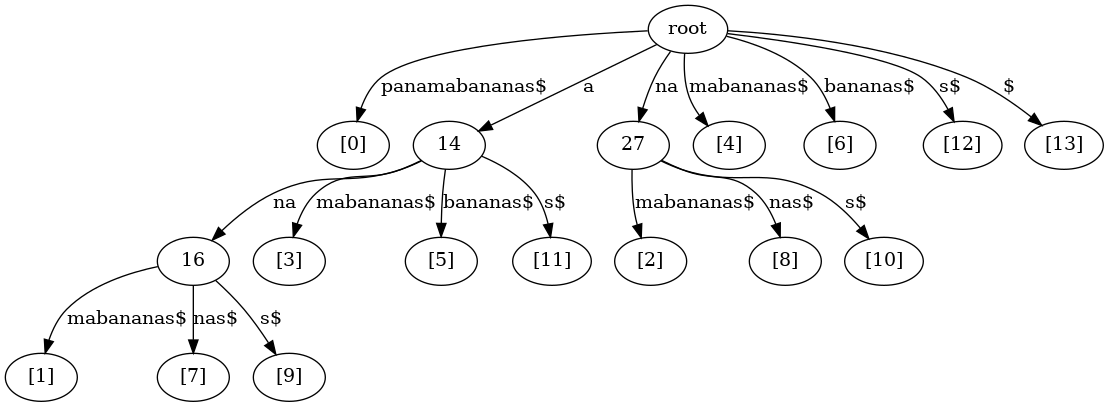

In [9]:
def suffix_tree_construction(text):
    trie,leaf_nodes = modified_suffix_trie(text)
    return trie

tree = suffix_tree_construction("panamabananas$")
show(tree)

In [12]:
to_adj(tree).index

Index(['root', '[0]', '14', '16', '[1]', '27', '[2]', '[3]', '[4]', '[5]',
       '[6]', '[7]', '[8]', '[9]', '[10]', '[11]', '[12]', '[13]'],
      dtype='object')

In [10]:
# Don't forget to push!